# **Downloading**

In [ ]:
%%capture
!pip install nwbwidgets
!pip install dandi
!pip install -U pynwb
!dandi download https://gui.dandiarchive.org/#/dandiset/000010/

# **Function**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np
import math as math
import os
import shutil
import torch

from pynwb import NWBHDF5IO
from nwbwidgets import nwb2widget

%matplotlib inline 

In [ ]:
def data_binning(path, bin=100):
  """
  
  """
  io = NWBHDF5IO(path, 'r')
  nwbfile = io.read()
  rate = nwbfile.units.sampling_rate[0]
  number_of_neuron = len(nwbfile.units.spike_times_index[:])
  number_of_trial = len(nwbfile.units.obs_intervals_index[0]) #All neuron has the same number of trials
  number_of_x = rate*5.5
  data = torch.zeros(math.ceil(number_of_x), number_of_neuron, number_of_trial)

  smin = 0
  smax = 5.5
  for trials in range(data.shape[2]):
    t_norm = nwbfile.units.obs_intervals[trials] 
    for nueron in range(data.shape[1]):
      n_norm = nwbfile.units.spike_times_index[nueron][:]
      x_norm = ( n_norm - t_norm[0] ) * (smax - smin) / ( t_norm[1] - t_norm[0]) + smin #normalize
      x_norm = x_norm[x_norm > 0]
      x_norm = x_norm[x_norm < 5.5]
      x_norm = x_norm*rate
      x_norm = [math.ceil(i) for i in x_norm]
      for x in x_norm:
        data[x, nueron, trials] = 1

  time_point = 20 * bin
  time_after_bin = math.ceil( data.shape[0] / time_point)
  data_new = torch.zeros(time_after_bin, number_of_neuron, number_of_trial)

  for trials in range(data.shape[2]):
    for nueron in range(data.shape[1]):
      for x in range(time_after_bin):
        log_data = data[time_point*x:time_point*(x+1),nueron,trials]
        data_new[x, nueron,trials] = torch.sum(log_data)
  return data_new, data.shape[1]

def export_data(sub=None, test=True, bin=100):
  """

  """
  if test:
    col_content = '/content/'
    main = os.path.join(col_content, sub)
    path, dirs, files = next(os.walk(main))
    for f in files:
      text = f.split('_')
      text = text[1]
      dir = os.path.join(main, text)
      if not os.path.exists(dir):
        os.makedirs(dir)
      ses = os.path.join(main, f)
      data, n = data_binning(ses, bin=bin)
      for num in range(n):
        data_save = data.permute(2,1,0);
        name = str(num + 1) + '.csv'
        np.savetxt(os.path.join(dir, name), data_save[:,num,:], delimiter=',')
  else:
    col_content = '/content/000010/'
    path, dirs_2, sub = next(os.walk(col_content))
    for s in dirs_2:
      main = os.path.join(col_content, s)
      path, dirs, files = next(os.walk(main))
      for f in files:
        text = f.split('_')
        text = text[1]
        dir = os.path.join(main, text)
        if not os.path.exists(dir):
          os.makedirs(dir)
        ses = os.path.join(main, f)
        data, n = data_binning(ses, bin=bin)
        for num in range(n):
          data_save = data.permute(2,1,0);
          name = str(num + 1) + '.csv'
          np.savetxt(os.path.join(dir, name), data_save[:,num,:], delimiter=',')

# **Data Exploring**

In [ ]:
data = data_binning('/content/000010/sub-217951/sub-217951_ses-20131010_obj-1wjcj56_behavior+ophys.nwb', bin=100)

In [ ]:
export_data(test=False, bin =100)

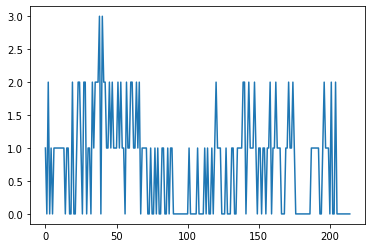

In [ ]:
plt.plot(data[:,10,40])